Investigate the glacier-scale and regional-scale trend in water area over time

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [5]:
# open the water by distance data for each glacier, format into a single df
c=0
df_all_area = []
df_all_norm_area = []
df_all_percent = []
df_all_norm_percent = []

for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>2: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific info    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water',
                             'annual_water_distances_binary_otsuoptimal_188_binned_accaqa.csv')
    df_g = pd.read_csv(path_open, index_col=None, header=0).squeeze()
    
    # rename columns
    old_cols = df_g.columns.values[1:]
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_g = df_g.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    # now we are going to divide by the total possible area in each band
    path_open = os.path.join(folder_glaciers, rgi_id, 'Water', 'debris_area_by_distance.csv')
    df_dca = pd.read_csv(path_open, index_col='band', header=0).squeeze().drop("Unnamed: 0", axis=1).T
    
    # rename columns
    old_cols = df_dca.columns.values[1:]
    new_cols = [ int(i.split("_")[0]) for i in old_cols ]
    df_dca = df_dca.rename(dict(zip(old_cols, new_cols)), axis=1)
    
    # add rgiid, region info
    for d in [df_g, df_dca]:
        d.insert(loc=0,column='rgi_id', value=rgi_id)
        d.insert(loc=1,column='o1region', value=o1region)
        d.insert(loc=2,column='o2region', value=o2region)
        d.insert(loc=3,column='o3region', value=o3region)
        d.insert(loc=4,column='length', value=int(new_cols[-1]))
    
    
    # normalize to 10 bands along glacier
    new_cols = np.array(new_cols)
    norm_bands = np.linspace(0,int(new_cols[-1])+1,11)
    
    # subset to these bands, sum for each
    df_norm_g = df_g[['rgi_id','o1region','o2region','o3region','length','year']].copy()
    df_dca_g = df_dca[['rgi_id','o1region','o2region','o3region','length']].copy()
    
    for i in range(10):
        bmin = norm_bands[i]
        bmax = norm_bands[i+1]
        bands_i = [ b for b in new_cols[ (new_cols>=bmin) & (new_cols<bmax) ] ]
        
        df_i = df_g[bands_i].sum(axis=1)
        df_norm_g.insert(loc=len(df_norm_g.columns),
                         column=(i+1)/10, value=df_i.values)
        
        df_i = df_dca[bands_i].sum(axis=1)
        df_dca_g.insert(loc=len(df_dca_g.columns),
                         column=(i+1)/10, value=df_i.values)
    
    df_all_norm_area.append(df_norm_g)
    df_all_area.append(df_g)
    
    # now we are going to divide df_norm_g by df_dca_g and df_g by df_dca
    cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    df_a = df_norm_g.copy()
    df_a[cs] = df_a[cs].div( df_dca_g[cs].values )
    
    df_b = df_g.copy()
    df_b[new_cols] = df_b[new_cols].div( df_dca[new_cols].values )
    
    df_all_norm_percent.append(df_a)
    df_all_percent.append(df_b)
    
# format into df
df_all_area = pd.concat(df_all_area)
df_all_norm_area = pd.concat(df_all_norm_area)
df_all_percent = pd.concat(df_all_percent)
df_all_norm_percent = pd.concat(df_all_norm_percent)

print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [6]:
# load in the list of lake-terminating glaciers, so we can remove those if we want
path_open = os.path.join(folder_datasets, 'lake-terminating glaciers', 'rgi_lake_terminating.csv')
df_lake_term = pd.read_csv(path_open)
rgi_lake_term = df_lake_term['rgi_id'].values
# rgi_lake_term

In [7]:
# create subsets of lake terminating vs non-lake terminating so we can compare
df_all_norm_percent_lt = df_all_norm_percent[df_all_norm_percent['rgi_id'].isin(rgi_lake_term)]
df_all_norm_percent_nlt = df_all_norm_percent[~df_all_norm_percent['rgi_id'].isin(rgi_lake_term)]

In [8]:
# choose which to use for all of the following regional plots
# including or excluding the glaciers that are lake terminating
df_to_use_from_here = df_all_norm_percent_nlt  #df_all_norm_percent, df_all_norm_percent_nlt

In [9]:
# lets make a separate df that includes only longer glaciers
df_long = df_to_use_from_here[df_to_use_from_here['length']>=2000]

In [10]:
print(len(df_to_use_from_here['rgi_id'].unique()))
print(len(df_long['rgi_id'].unique()))

750
626


In [11]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [12]:
# plot a single glacier's data over time
def plot_single_glacier(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name


    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]

    # subset to this glacier's data
    g_df = df_all_norm_percent[df_all_norm_percent['rgi_id']==rgi_id]

    # define intervals to use
    intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

    # iterate through a color ramp. new color for each interval
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))


    # initiate figure
    fig,axs = plt.subplots(figsize=(6,3))

    # define xs of the plot
    xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # for each interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
        areas = subset_df.median(axis=0)#.values

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        axs.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

    # add legend
    axs.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

    # formatting
    axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    axs.set_xlabel("Distance from terminus")
    axs.set_ylabel("SGL Area (%)")
    axs.set_ylim(0,)

    # title
    glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]
    axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

    plt.tight_layout()

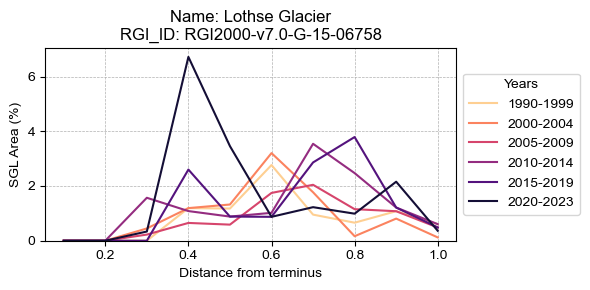

In [13]:
rgi_id = 'RGI2000-v7.0-G-15-08331' # choose which you want to provide
glacier_name = 'Loth'
plot_single_glacier(rgi_id, glacier_name)

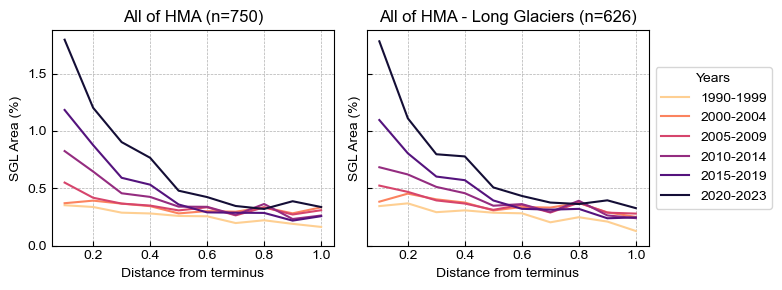

In [14]:
# plot the entire region

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]



# define xs of the plot
xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            
# initiate figure
fig,axs = plt.subplots(1,2, figsize=(8,3), sharey='row', sharex=True)

### one column for all glaciers, one column for long glaciers only
for col in [0,1]:
    
    ax = axs[col]
    if col==0: df_to_use = df_to_use_from_here
    else: df_to_use = df_long
    
    # reset color iterator each time
    colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
    
    # count number of glaciers included
    n_glaciers = len(df_to_use['rgi_id'].unique())

    # for each interval, subset the data and plot it
    for interval in intervals:

        # format and subset
        ymin = interval[0]
        ymax = interval[1]
        subset_df = df_to_use[ (df_to_use['year']>=ymin) & (df_to_use['year']<=ymax) ][xs]
        areas = subset_df.mean(axis=0)#.values

        # grab which color we want to use
        color_to_use = next(colors_to_use)

        # plot
        ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

    # formatting
    ax.tick_params(axis="both",direction="in")
    ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
    ax.set_xlabel("Distance from terminus")
    ax.set_ylabel("SGL Area (%)")
    ax.set_ylim(0,)

    # title
    if col==1:
        ax.set_title(f"All of HMA - Long Glaciers (n={n_glaciers})")
    else:
        ax.set_title(f"All of HMA (n={n_glaciers})")

# add legend to only one plot
axs[1].legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

plt.tight_layout()

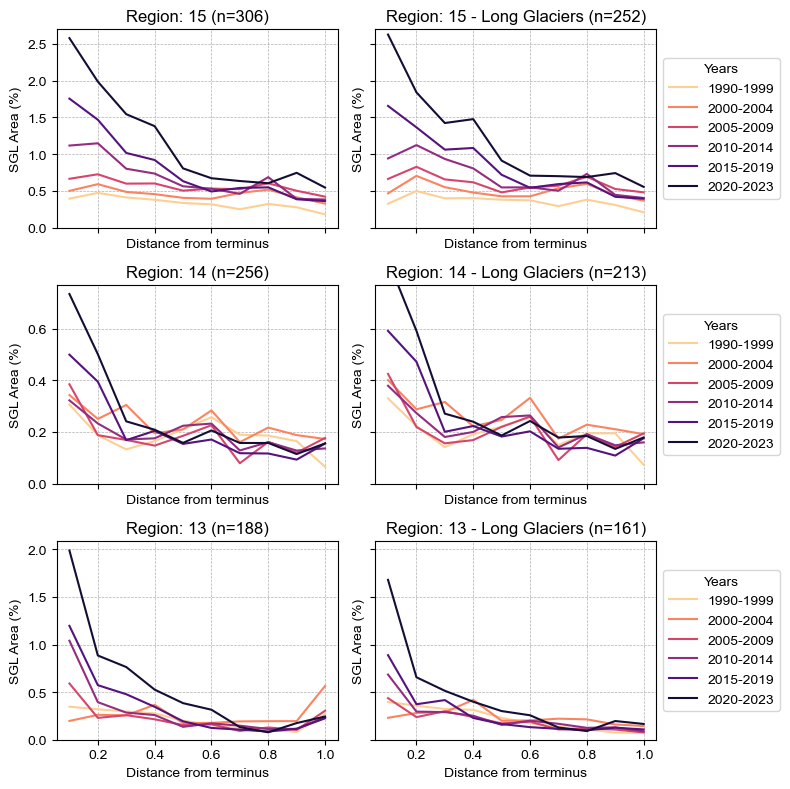

In [15]:
# plot every 01 region

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0   
for region in ['15','14','13']:

    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long
    
        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o1region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

        # define xs of the plot
        xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
        
        # add legend to only right column
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))
    c+=1

plt.tight_layout()

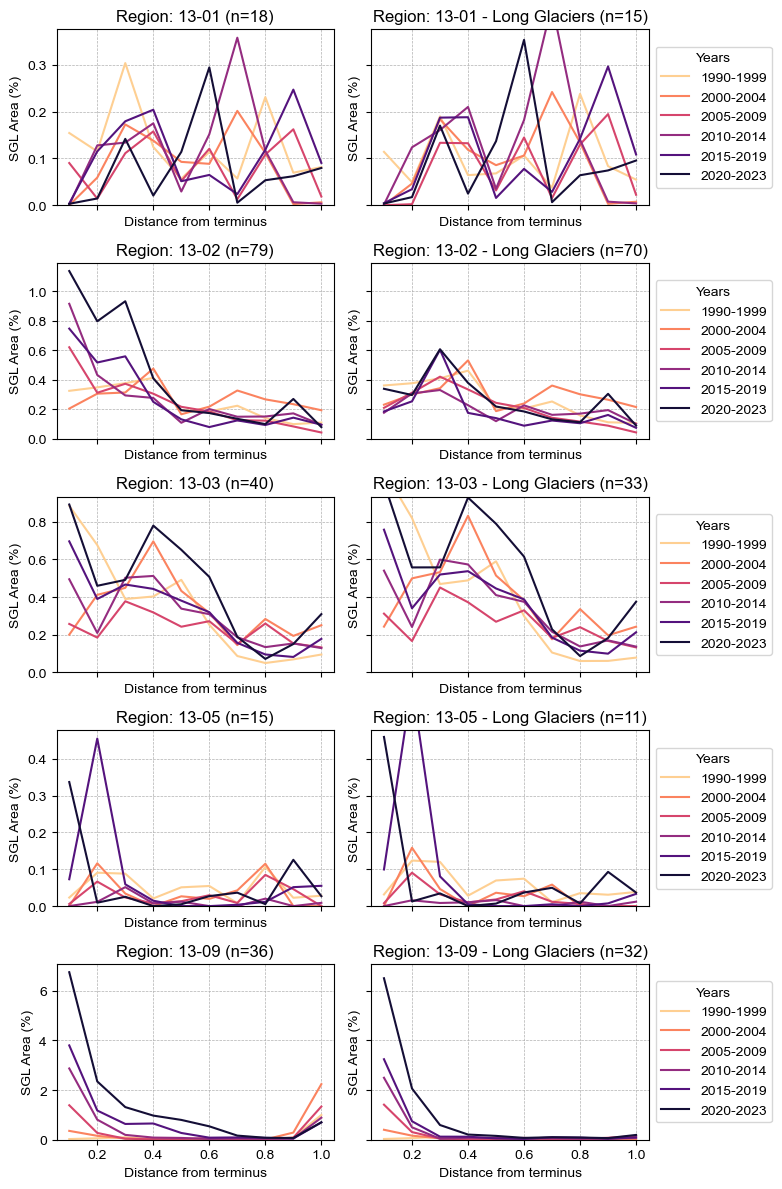

In [16]:
# plot every 02 region - in region 13

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]


# initiate figure
fig,axs = plt.subplots(5,2, figsize=(8,12), sharey='row', sharex=True)

c=0
for region in ['13-01', '13-02', '13-03', '13-05', '13-09']:

    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long
        
        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))

        # define xs of the plot
        xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend to only right column
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()

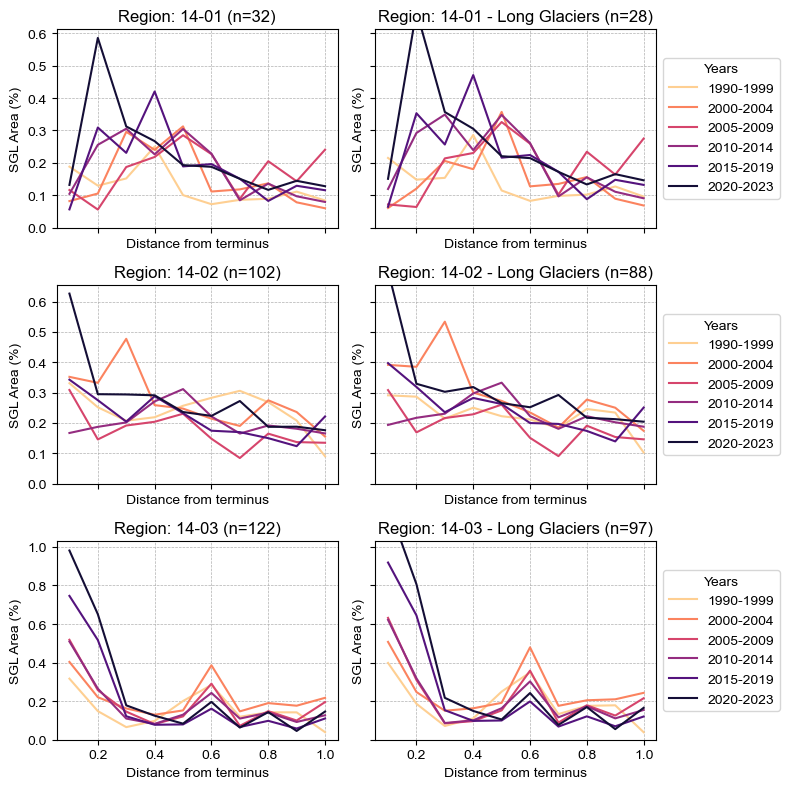

In [17]:
# plot every 02 region - in region 14

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# define xs of the plot
xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0
for region in ['14-01', '14-02', '14-03']:
    
    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long

        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
        
        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()

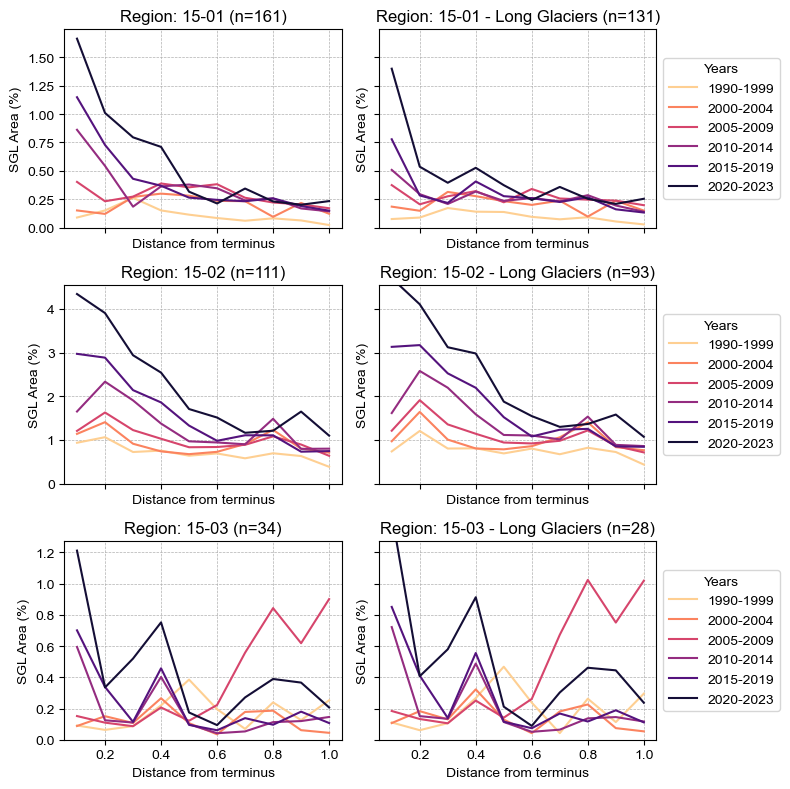

In [18]:
# plot every 02 region - in region 15

# define intervals to use
intervals = [[1990,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023]]

# define xs of the plot
xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# initiate figure
fig,axs = plt.subplots(3,2, figsize=(8,8), sharey='row', sharex=True)

c=0
for region in ['15-01', '15-02', '15-03']:
    
    for col in [0,1]:
    
        ax = axs[c,col]
        if col==0: df_to_use = df_to_use_from_here
        else: df_to_use = df_long

        # subset to this glacier's data
        g_df = df_to_use[df_to_use['o2region']==region]
        
        # count number of glaciers included
        n_glaciers = len(g_df['rgi_id'].unique())

        # iterate through a color ramp. new color for each interval
        colors_to_use = iter(plt.cm.magma_r(np.linspace(0.1, 0.9, len(intervals))))
        
        # for each interval, subset the data and plot it
        for interval in intervals:

            # format and subset
            ymin = interval[0]
            ymax = interval[1]
            subset_df = g_df[ (g_df['year']>=ymin) & (g_df['year']<=ymax) ][xs]
            areas = subset_df.mean(axis=0)#.values

            # grab which color we want to use
            color_to_use = next(colors_to_use)

            # plot
            ax.plot(xs, areas*100, label=f"{ymin}-{ymax}", color=color_to_use)

        # add legend
        if col==1: ax.legend(loc='center left', title='Years', bbox_to_anchor=(1,0.5))

        # formatting
        ax.grid(zorder=1, linestyle='dashed', linewidth=0.5)
        ax.set_xlabel("Distance from terminus")
        ax.set_ylabel("SGL Area (%)")
        ax.set_ylim(0,)

        # title
        if col==1: ax.set_title(f"Region: {region} - Long Glaciers (n={n_glaciers})")
        else: ax.set_title(f"Region: {region} (n={n_glaciers})")
    c+=1

plt.tight_layout()